In [1]:



from google.colab import drive

drive.mount('/content/drive')




Mounted at /content/drive


In [6]:
  import zipfile
  import os

  # Path to your dataset zip in Drive
  zip_path = "/content/drive/MyDrive/dataset/archive.zip"  # change this

  # Unzip into /content/data
  extract_path = "/content/data"
  os.makedirs(extract_path, exist_ok=True)

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)

  print("Unzipped to:", extract_path)


Unzipped to: /content/data


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
# Data transformations (augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # since grayscale
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),

    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset
train_dataset = datasets.ImageFolder(root="/content/data/train", transform=train_transform)
test_dataset  = datasets.ImageFolder(root="/content/data/test",  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes)


Train samples: 28709
Test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [9]:
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Modify last FC layer for 7 classes (FER-2013 emotions)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),  # helps generalization
    nn.Linear(num_ftrs, 7)
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


In [10]:


# Label smoothing loss (better than plain CrossEntropy)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Cosine learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [11]:
  def train_model(model, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        train_acc = 100 * correct / total


        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_resnet50_fer2013.pth")

    print("Best Validation Accuracy:", best_acc)
    return model

model = train_model(model, criterion, optimizer, scheduler, epochs=15)



Epoch 1/15, Train Acc: 54.46%, Val Acc: 61.70%
Epoch 2/15, Train Acc: 64.40%, Val Acc: 64.04%
Epoch 3/15, Train Acc: 68.48%, Val Acc: 65.77%
Epoch 4/15, Train Acc: 72.42%, Val Acc: 67.80%
Epoch 5/15, Train Acc: 76.37%, Val Acc: 69.25%
Epoch 6/15, Train Acc: 81.51%, Val Acc: 69.17%
Epoch 7/15, Train Acc: 86.90%, Val Acc: 69.70%
Epoch 8/15, Train Acc: 91.54%, Val Acc: 70.16%
Epoch 9/15, Train Acc: 94.37%, Val Acc: 70.65%
Epoch 10/15, Train Acc: 95.90%, Val Acc: 70.40%
Epoch 11/15, Train Acc: 96.35%, Val Acc: 70.63%
Epoch 12/15, Train Acc: 96.18%, Val Acc: 70.24%
Epoch 13/15, Train Acc: 96.12%, Val Acc: 70.16%
Epoch 14/15, Train Acc: 95.81%, Val Acc: 69.95%
Epoch 15/15, Train Acc: 94.29%, Val Acc: 69.43%
Best Validation Accuracy: 70.64641961549178


In [15]:
save_path = "/content/best_resnet50_fer2013.pth"

torch.save(model.state_dict(), save_path)

print("Model saved at:", save_path)

Model saved at: /content/best_resnet50_fer2013.pth


In [27]:
from google.colab import files
files.download("emotion_model_weights.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

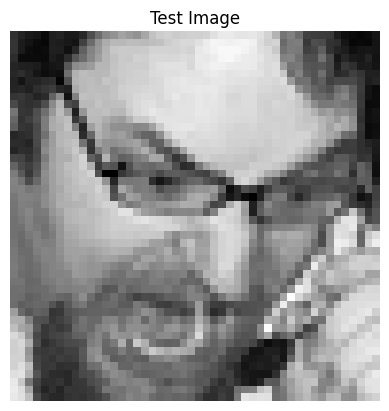

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to a test image
img_path = "/content/data/test/angry/PrivateTest_10131363.jpg"  # change to any test image

# Load and preprocess image
img = Image.open(img_path).convert("L")  # grayscale
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])
input_img = transform(img).unsqueeze(0).to(device)

# Display image
plt.imshow(img, cmap='gray')
plt.title("Test Image")
plt.axis('off')
plt.show()


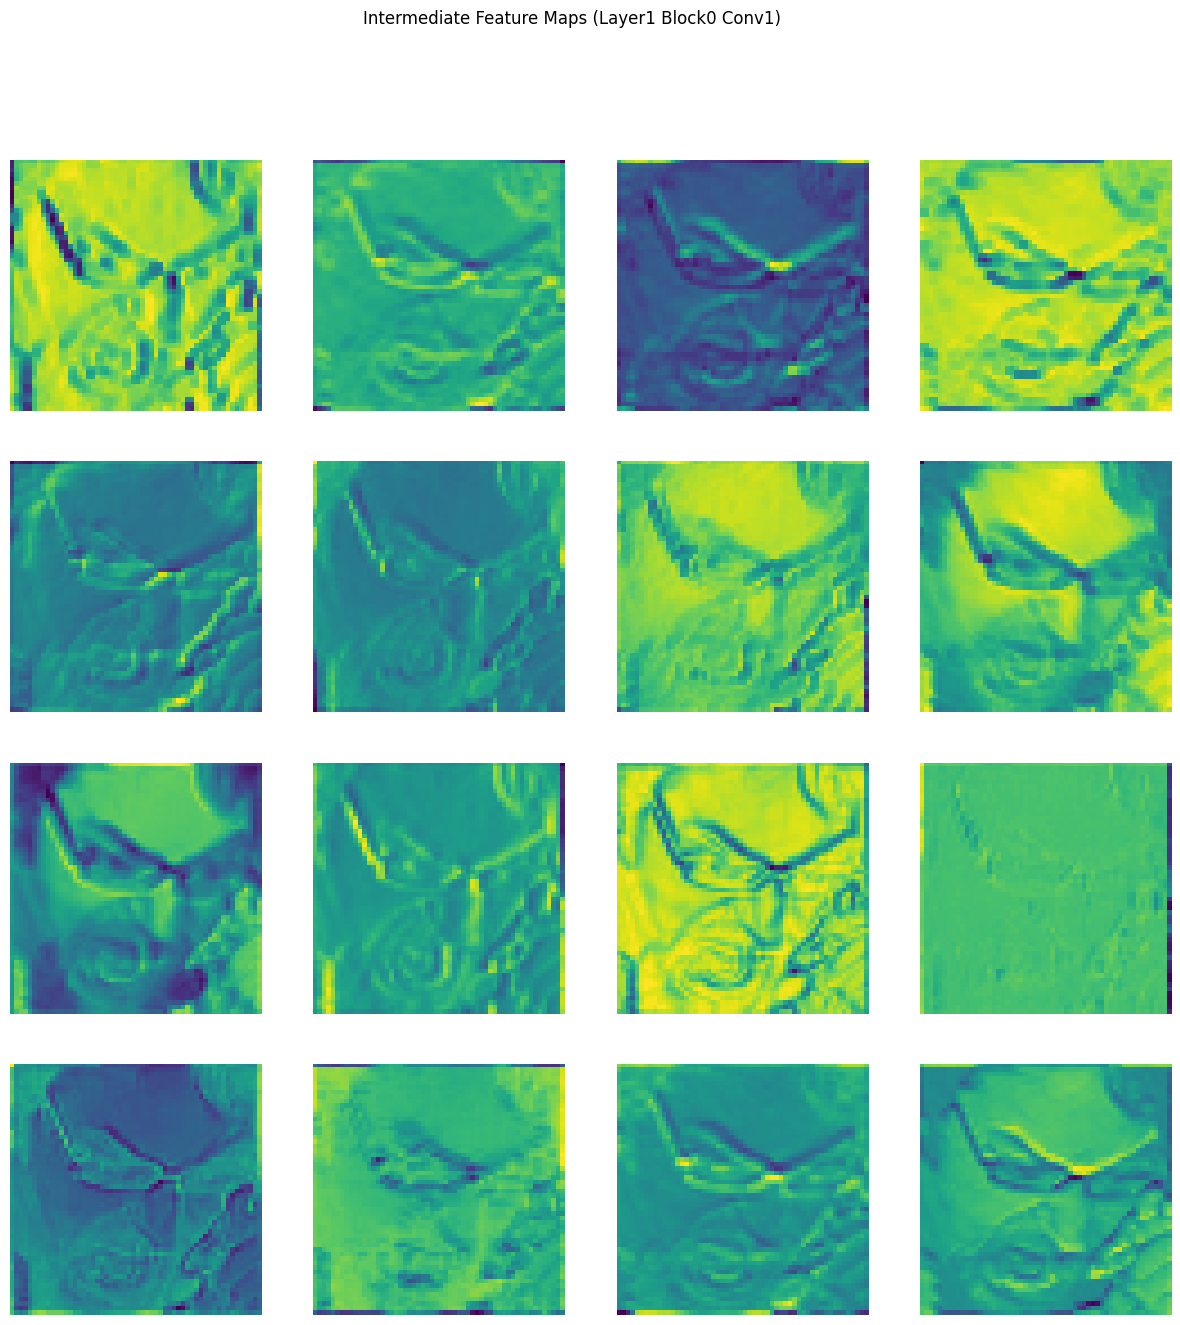

In [19]:
# Convert grayscale input to 3 channels
input_img_rgb = input_img.repeat(1, 3, 1, 1)  # from [1,1,224,224] -> [1,3,224,224]

# Choose a convolutional layer to visualize (e.g., layer1 block0)
layer = model.layer1[0].conv1  # first conv in first residual block

# Forward hook to capture activations
activations = []
def hook_fn(module, input, output):
    activations.append(output)

hook = layer.register_forward_hook(hook_fn)

# Forward pass
_ = model(input_img_rgb)

# Remove hook
hook.remove()

# Visualize feature maps
act = activations[0].cpu().detach()
num_features = act.shape[1]
plt.figure(figsize=(15, 15))
for i in range(min(num_features, 16)):  # show first 16 feature maps
    plt.subplot(4, 4, i+1)
    plt.imshow(act[0, i, :, :], cmap='viridis')
    plt.axis('off')
plt.suptitle("Intermediate Feature Maps (Layer1 Block0 Conv1)")
plt.show()



In [26]:
torch.save(model.state_dict(), "emotion_model_weights.pth")



In [ ]:
from google.colab import files
files.download("emotion_model_weights.pth")


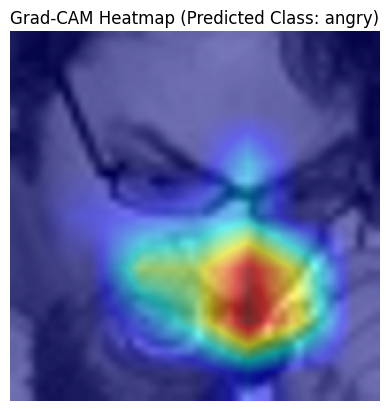

In [25]:
!pip install --upgrade grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

# Convert grayscale input to 3 channels
input_img_rgb = input_img.repeat(1, 3, 1, 1)  # [1,1,224,224] -> [1,3,224,224]

# Convert grayscale image to numpy and expand to 3 channels
img_array = np.array(img.resize((224,224)), dtype=np.float32)/255.0  # [224,224]
img_rgb = np.stack([img_array]*3, axis=2)  # [224,224,3]

# Use last convolutional layer in ResNet
target_layer = model.layer4[-1].conv3

# Initialize Grad-CAM (no use_cuda argument)
cam = GradCAM(model=model, target_layers=[target_layer])

# Predict class for the image
pred_class = torch.argmax(model(input_img_rgb)).item()
targets = [ClassifierOutputTarget(pred_class)]

# Compute Grad-CAM
grayscale_cam = cam(input_tensor=input_img_rgb, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Overlay CAM on image
cam_image = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.title(f"Grad-CAM Heatmap (Predicted Class: {train_dataset.classes[pred_class]})")
plt.axis('off')
plt.show()
